
### Variables
1.  **Observations (Emissions):** The input string.
    * `C` (Charged)
    * `N` (Neutral)
    * `H` (Hydrophobic)
2.  **Hidden States:** The labels you want to predict.
    * `State 0`: Non-transmembrane (Outside the wall).
    * `State 1`: Transmembrane (Inside the wall).



In [151]:
with open('Sequence_case2.txt', 'r') as f:
  case = f.read()

protein_sequence = case.rsplit('\n')[1]
len_protein_sequence = len(protein_sequence)
print(protein_sequence)

status_transmembrane = case.rsplit('\n')[4]
len_status_transmembrane = len(status_transmembrane)
print(status_transmembrane)

# check if both are same length

print(len_protein_sequence)
print(len_status_transmembrane)

assert(len_protein_sequence == len_status_transmembrane)

NNCCNNHCNCNNCNNHNCHCCCHHNHHNNHHHNCHNNNHNHNNHCNNHHNCHHCCCCNNHHCNNCNNNNNNHNCNNHNNHNHNNNHNNNHHHCHHNHHCNNHNCHCCCNCNNCCCHNCNNCNNNHHHNHNCNHNHNNNHNCNNNNCNHHHCNNNNNNNNNHHNHHNNNNNHNCHNCCHNCCNHNCNHNHHHNNNHHNNHNNNHNCNHCCNCCNCHCNHHHHHHNHHHNNHNNNHHNHCCNCCCHHHCNNCCCCNCCHNNNCNNCHNHCHCNNNHHNNHNNNNHHHNNNNHNNCNNNNNNCCCHNNHNHNHCNNCNHNHHHNNNNHHNNHNNNNNHHNCNCCNNCCHCCNNNNHNNHCNNCCNNCNHCCHNNCHNHHNNHNHNNHHHHNCNNCCNNCHNNNNNNNNHHHHHHHHNCNNNCHCNHNNNNCNCNNHCCNCHCNNNC
00000000000000000000001111111111111111111110000000000000000000000000000000111111111111111111111000000000000000000000000001111111111111111111110000000000001111111111111111111110000000011111111111111111111100000000000011111111111111111111100000000000000000000000000000000011111111111111111111111111111111111111111100001111111111111111111110000000000000000000000000000000001111111111111111111110000011111111111111111111100000000000000000000000000
443
443


(1) Use occurrence counts to compute estimates for model parameters.

In [152]:
st_count: dict[str, int] = {}

st_prev: str = status_transmembrane[0]
for i in status_transmembrane[1:]:
  combination = st_prev + i
  if combination in st_count:
    st_count[combination] += 1
  else:
    st_count[combination] = 1
  st_prev = i

st_trans_prob: dict[str, float] = {}
for s_from in ['0', '1']:
  total = sum(st_count.get(s_from + s_to, 0) for s_to in ['0', '1'])
  if total > 0:
    st_trans_prob[s_from + '0'] = st_count.get(s_from + '0', 0) / total
    st_trans_prob[s_from + '1'] = st_count.get(s_from + '1', 0) / total

In [153]:
ps_count: dict[str, int] = {}

ps_prev: str = protein_sequence[0]
for i in protein_sequence[1:]:
    combination = ps_prev + i
    ps_count[combination] = ps_count.get(combination, 0) + 1
    ps_prev = i

ps_trans_prob: dict[str, float] = {}
for p_from in ['C', 'N', 'H']:
  total = sum(ps_count.get(p_from + p_to, 0) for p_to in ['C', 'N', 'H'])
  if total > 0:
    ps_trans_prob[p_from + 'C'] = ps_count.get(p_from + 'C', 0) / total
    ps_trans_prob[p_from + 'N'] = ps_count.get(p_from + 'N', 0) / total
    ps_trans_prob[p_from + 'H'] = ps_count.get(p_from + 'H', 0) / total

In [154]:
hmm_emission_prob: dict[str, int] = {}

for i, v in enumerate(protein_sequence):
    combination = v + '_' + status_transmembrane[i]
    hmm_emission_prob[combination] = hmm_emission_prob.get(combination, 0) + 1

assert(sum(hmm_emission_prob.values()) == len_protein_sequence == len_status_transmembrane)

(2) Implement the Viterbi algorithm and use it to determine the prediction
accuracy of your model (in terms of numbers of correctly and incorrectly
annotated amino acids).

In [155]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
# as prep for the viterbi algo we create the necessary np.array's

states = ['0', '1']
observations = ['C', 'N', 'H']

state_to_idx = {s: i for i, s in enumerate(states)}
obs_to_idx = {o: i for i, o in enumerate(observations)}


In [157]:
# transition matrix: A
A = np.zeros((len(states), len(states)))
for s_from in states:
    total = sum(st_count.get(s_from + s_to, 0) for s_to in states)
    for s_to in states:
        A[state_to_idx[s_from], state_to_idx[s_to]] = st_count.get(s_from + s_to, 0) / total if total > 0 else 0

# state distribution: C
C = np.zeros(len(states))
C[state_to_idx[status_transmembrane[0]]] = 1.0

# emission matrix: B
B = np.zeros((len(states), len(observations)))
for s in states:
    total = sum(hmm_emission_prob.get(o + '_' + s, 0) for o in observations)
    for o in observations:
        B[state_to_idx[s], obs_to_idx[o]] = hmm_emission_prob.get(o + '_' + s, 0) / total if total > 0 else 0

# observation sequence: O
O = np.array([obs_to_idx[o] for o in protein_sequence])

In [162]:
from viterbi import viterbi

pred_acc = viterbi(A, C, B, O)

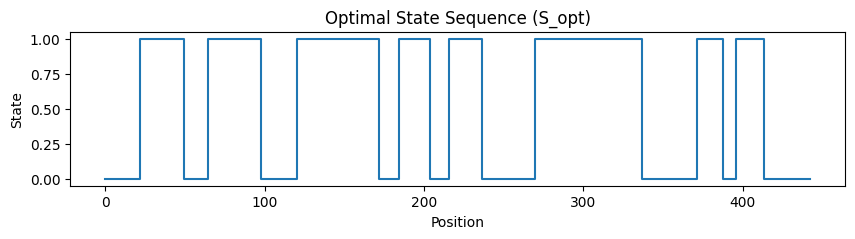

In [159]:
S_opt, D, E = pred_acc

plt.figure(figsize=(10, 2))
plt.plot(S_opt, drawstyle='steps-mid')
plt.title('Optimal State Sequence (S_opt)')
plt.xlabel('Position')
plt.ylabel('State')
plt.show()

In [165]:
correct = sum([int(str(s) == t) for s, t in zip(S_opt, status_transmembrane)])
total = len(S_opt)
accuracy = correct / total
print(f"Prediction accuracy: {accuracy:.2%} ({correct}/{total})")

Prediction accuracy: 89.16% (395/443)


(3) Given the constructed HMM calculate the conditional probabilities (display
the result in matrix-form: P (C I C), P(C I N), P(C I H), … P(H I H).


In [160]:
import pandas as pd

matrix = pd.DataFrame(
    [[ps_trans_prob.get(f'{row}{col}', 0) for col in ['C', 'N', 'H']] for row in ['C', 'N', 'H']],
    index=['C', 'N', 'H'],
    columns=['C', 'N', 'H']
)
print(matrix)

          C         N         H
C  0.309278  0.474227  0.216495
N  0.213953  0.502326  0.283721
H  0.169231  0.461538  0.369231


In [ ]:
# Plot the amino acid transition probability matrix as a heatmap
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Amino Acid Transition Probabilities")
plt.xlabel("To")
plt.ylabel("From")
plt.show()

(4) Change the emission probabilities to radically different values. Is it easier or
more difficult to annotate the hidden states with certainty? How could you
change the emission probabilities in order to reduce the HMM to a simple
Markov chain model? Define the resulting model.

In [161]:
B[:] = 1 / len(observations)